In [2]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [4]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [200, 500]
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Extract Training Data

In [27]:
# Extract training features - random subset

training_addresses = defaultdict(list)

labels_found = set([])

# for stack in all_annotated_nissl_stacks:
for stack in all_annotated_ntb_stacks:

    annotation_grid_indices_fn = os.path.join(ANNOTATION_ROOTDIR, stack, stack + '_annotation_grid_indices.h5')
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels_found = labels_found | labels_this_stack
    
    training_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, 
                                                  num_samples_per_landmark=1000)
    
    for name, addresses in training_addresses_sec_idx.iteritems():
        training_addresses[name] += [(stack, ) + addr for addr in addresses]
        
training_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

In [30]:
training_features = apply_function_to_dict(addresses_to_features, training_addresses)

('MD635', 75)
('MD635', 76)
('MD635', 77)
('MD635', 78)
('MD635', 79)
('MD635', 80)
('MD635', 81)
('MD635', 82)


Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @31786
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @28772
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @31537
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @35047
Patch in annotation but not in mask: MD635 82 MD635-F28-2016.05.18-21.46.26_MD635_1_0082 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @30782


('MD635', 83)
('MD635', 84)
('MD635', 85)
('MD635', 86)
('MD635', 87)


Patch in annotation but not in mask: MD635 87 MD635-F29-2016.05.18-22.01.14_MD635_3_0087 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @94


('MD635', 88)


Patch in annotation but not in mask: MD635 88 MD635-F30-2016.05.18-22.15.39_MD635_1_0088 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @170


('MD635', 89)
('MD635', 90)
('MD635', 91)
('MD635', 92)
('MD635', 94)


Patch in annotation but not in mask: MD635 94 MD635-F32-2016.05.18-22.50.16_MD635_1_0094 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @123


('MD635', 95)


Patch in annotation but not in mask: MD635 95 MD635-F32-2016.05.18-22.50.16_MD635_2_0095 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @157


('MD635', 96)
('MD635', 97)


Patch in annotation but not in mask: MD635 97 MD635-F33-2016.05.18-23.06.34_MD635_1_0097 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @50


('MD635', 98)


Patch in annotation but not in mask: MD635 98 MD635-F33-2016.05.18-23.06.34_MD635_2_0098 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @220
Patch in annotation but not in mask: MD635 98 MD635-F33-2016.05.18-23.06.34_MD635_2_0098 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @146


('MD635', 99)
('MD635', 100)


Patch in annotation but not in mask: MD635 100 MD635-F34-2016.05.18-23.23.55_MD635_1_0100 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @188
Patch in annotation but not in mask: MD635 100 MD635-F34-2016.05.18-23.23.55_MD635_1_0100 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @72


('MD635', 101)


Patch in annotation but not in mask: MD635 101 MD635-F34-2016.05.18-23.23.55_MD635_2_0101 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @207
Patch in annotation but not in mask: MD635 101 MD635-F34-2016.05.18-23.23.55_MD635_2_0101 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @167


('MD635', 102)
('MD635', 103)
('MD635', 104)


Patch in annotation but not in mask: MD635 104 MD635-F35-2016.05.18-23.40.52_MD635_2_0104 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @160


('MD635', 105)


Patch in annotation but not in mask: MD635 105 MD635-F35-2016.05.18-23.40.52_MD635_3_0105 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @211
Patch in annotation but not in mask: MD635 105 MD635-F35-2016.05.18-23.40.52_MD635_3_0105 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @222


('MD635', 106)


Patch in annotation but not in mask: MD635 106 MD635-F36-2016.05.18-23.59.35_MD635_1_0106 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @177


('MD635', 107)


Patch in annotation but not in mask: MD635 107 MD635-F36-2016.05.18-23.59.35_MD635_2_0107 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @222


('MD635', 108)
('MD635', 109)
('MD635', 110)
('MD635', 111)
('MD635', 112)


Patch in annotation but not in mask: MD635 112 MD635-F38-2016.05.19-00.34.28_MD635_1_0112 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @196


('MD635', 113)
('MD635', 114)
('MD635', 115)
('MD635', 116)
('MD635', 117)


Patch in annotation but not in mask: MD635 117 MD635-F39-2016.05.19-00.52.10_MD635_3_0117 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @63


('MD635', 118)
('MD635', 119)


Patch in annotation but not in mask: MD635 119 MD635-F40-2016.05.19-01.08.51_MD635_2_0119 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @133


('MD635', 120)


Patch in annotation but not in mask: MD635 120 MD635-F40-2016.05.19-01.08.51_MD635_3_0120 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @60
Patch in annotation but not in mask: MD635 120 MD635-F40-2016.05.19-01.08.51_MD635_3_0120 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @201


('MD635', 121)
('MD635', 122)
('MD635', 123)


Patch in annotation but not in mask: MD635 123 MD635-F41-2016.05.19-01.28.39_MD635_3_0123 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @80
Patch in annotation but not in mask: MD635 123 MD635-F41-2016.05.19-01.28.39_MD635_3_0123 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @178


('MD635', 124)
('MD635', 125)


Patch in annotation but not in mask: MD635 125 MD635-F42-2016.05.19-01.47.04_MD635_2_0125 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @122


('MD635', 126)
('MD635', 127)


Patch in annotation but not in mask: MD635 127 MD635-F43-2016.05.19-02.06.14_MD635_1_0127 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @85


('MD635', 128)
('MD635', 129)
('MD635', 130)
('MD635', 131)


Patch in annotation but not in mask: MD635 131 MD635-F44-2016.05.19-02.24.57_MD635_2_0131 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @188


('MD635', 132)
('MD635', 133)


Patch in annotation but not in mask: MD635 133 MD635-F45-2016.05.19-02.43.09_MD635_1_0133 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @78


('MD635', 134)
('MD635', 135)


Patch in annotation but not in mask: MD635 135 MD635-F45-2016.05.19-02.43.09_MD635_3_0135 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @86


('MD635', 136)


Patch in annotation but not in mask: MD635 136 MD635-F46-2016.05.19-03.02.11_MD635_1_0136 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @180
Patch in annotation but not in mask: MD635 136 MD635-F46-2016.05.19-03.02.11_MD635_1_0136 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @218


('MD635', 137)


Patch in annotation but not in mask: MD635 137 MD635-F46-2016.05.19-03.02.11_MD635_2_0137 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @227


('MD635', 138)


Patch in annotation but not in mask: MD635 138 MD635-F46-2016.05.19-03.02.11_MD635_3_0138 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @197


('MD635', 139)
('MD635', 140)


Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @89
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41600
Patch in annotation but not in mask: MD635 140 MD635-F47-2016.05.19-03.19.48_MD635_2_0140 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @41851


('MD635', 141)
('MD635', 142)
('MD635', 143)


Patch in annotation but not in mask: MD635 143 MD635-F48-2016.05.19-03.40.12_MD635_2_0143 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @207


('MD635', 144)


Patch in annotation but not in mask: MD635 144 MD635-F48-2016.05.19-03.40.12_MD635_3_0144 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @22


('MD635', 145)


Patch in annotation but not in mask: MD635 145 MD635-F49-2016.05.19-03.59.43_MD635_1_0145 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @153
Patch in annotation but not in mask: MD635 145 MD635-F49-2016.05.19-03.59.43_MD635_1_0145 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @64


('MD635', 146)
('MD635', 147)


Patch in annotation but not in mask: MD635 147 MD635-F49-2016.05.23-14.25.13_MD635_3_0147 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @196


('MD635', 148)
('MD635', 149)


Patch in annotation but not in mask: MD635 149 MD635-F50-2016.05.23-14.45.07_MD635_2_0149 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @37
Patch in annotation but not in mask: MD635 149 MD635-F50-2016.05.23-14.45.07_MD635_2_0149 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @64


('MD635', 150)


Patch in annotation but not in mask: MD635 150 MD635-F50-2016.05.23-14.45.07_MD635_3_0150 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @167
Patch in annotation but not in mask: MD635 150 MD635-F50-2016.05.23-14.45.07_MD635_3_0150 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @142
Patch in annotation but not in mask: MD635 150 MD635-F50-2016.05.23-14.45.07_MD635_3_0150 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @90


('MD635', 151)
('MD635', 152)


Patch in annotation but not in mask: MD635 152 MD635-F51-2016.05.23-15.04.39_MD635_2_0152 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20


('MD635', 153)
('MD635', 154)


Patch in annotation but not in mask: MD635 154 MD635-F52-2016.05.23-15.23.47_MD635_1_0154 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @40
Patch in annotation but not in mask: MD635 154 MD635-F52-2016.05.23-15.23.47_MD635_1_0154 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @27
Patch in annotation but not in mask: MD635 154 MD635-F52-2016.05.23-15.23.47_MD635_1_0154 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @119


('MD635', 155)
('MD635', 156)
('MD635', 157)
('MD635', 158)


Patch in annotation but not in mask: MD635 158 MD635-F53-2016.05.19-05.14.50_MD635_2_0158 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @65


('MD635', 159)


Patch in annotation but not in mask: MD635 159 MD635-F53-2016.05.19-05.14.50_MD635_3_0159 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @183


('MD635', 160)
('MD635', 161)
('MD635', 162)
('MD635', 163)
('MD635', 164)
('MD635', 165)
('MD635', 166)
('MD635', 167)


Patch in annotation but not in mask: MD635 167 MD635-F57-2016.05.19-06.32.00_MD635_2_0170 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @66


('MD635', 168)
('MD635', 169)


Patch in annotation but not in mask: MD635 169 MD635-F58-2016.05.19-06.52.57_MD635_2_0173 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @81


('MD635', 170)


Patch in annotation but not in mask: MD635 170 MD635-F59-2016.05.19-07.14.24_MD635_1_0175 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @82
Patch in annotation but not in mask: MD635 170 MD635-F59-2016.05.19-07.14.24_MD635_1_0175 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @192


('MD635', 171)


Patch in annotation but not in mask: MD635 171 MD635-F59-2016.05.19-07.14.24_MD635_2_0176 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @54
Patch in annotation but not in mask: MD635 171 MD635-F59-2016.05.19-07.14.24_MD635_2_0176 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @223


('MD635', 172)
('MD635', 173)


Patch in annotation but not in mask: MD635 173 MD635-F60-2016.05.19-07.35.14_MD635_2_0179 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @182
Patch in annotation but not in mask: MD635 173 MD635-F60-2016.05.19-07.35.14_MD635_2_0179 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @221


('MD635', 174)


Patch in annotation but not in mask: MD635 174 MD635-F61-2016.05.19-07.56.43_MD635_1_0181 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @222
Patch in annotation but not in mask: MD635 174 MD635-F61-2016.05.19-07.56.43_MD635_1_0181 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @227
Patch in annotation but not in mask: MD635 174 MD635-F61-2016.05.19-07.56.43_MD635_1_0181 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @145


('MD635', 175)


Patch in annotation but not in mask: MD635 175 MD635-F61-2016.05.19-07.56.43_MD635_2_0182 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @37


('MD635', 176)


Patch in annotation but not in mask: MD635 176 MD635-F62-2016.05.19-08.18.25_MD635_1_0184 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @112


('MD635', 177)


Patch in annotation but not in mask: MD635 177 MD635-F62-2016.05.19-08.18.25_MD635_2_0185 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @47


('MD635', 178)
('MD635', 179)
('MD635', 180)
('MD635', 181)
('MD635', 182)
('MD635', 183)
('MD635', 184)
('MD635', 185)


Patch in annotation but not in mask: MD635 185 MD635-F66-2016.05.19-09.39.33_MD635_2_0197 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @147


('MD635', 186)
('MD635', 187)
('MD635', 188)
('MD635', 189)
('MD635', 190)


Patch in annotation but not in mask: MD635 190 MD635-F69-2016.05.19-10.38.34_MD635_1_0205 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @58


('MD635', 191)


Patch in annotation but not in mask: MD635 191 MD635-F69-2016.05.19-10.38.34_MD635_2_0206 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @176


('MD635', 192)
('MD635', 193)
('MD635', 194)
('MD635', 195)
('MD635', 196)
('MD635', 197)


Patch in annotation but not in mask: MD635 197 MD635-F72-2016.05.19-11.37.07_MD635_2_0215 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @14056


('MD635', 198)


Patch in annotation but not in mask: MD635 198 MD635-F73-2016.05.19-11.56.44_MD635_1_0217 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @16315
Patch in annotation but not in mask: MD635 198 MD635-F73-2016.05.19-11.56.44_MD635_1_0217 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @136


('MD635', 199)


Patch in annotation but not in mask: MD635 199 MD635-F73-2016.05.19-11.56.44_MD635_2_0218 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @140


('MD635', 200)


Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @19781
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20026
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21542
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21536
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @20786
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @21785
Patch in annotation but not in mask: MD635 200 MD635-F74-2016.05.19-12.15.18_MD635_1_0220 alignedTo 

('MD635', 201)
('MD635', 202)


Patch in annotation but not in mask: MD635 202 MD635-F75-2016.05.19-12.32.46_MD635_1_0223 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @16566


('MD635', 203)
('MD635', 204)


Patch in annotation but not in mask: MD635 204 MD635-F76-2016.05.19-12.50.14_MD635_1_0226 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @241
Patch in annotation but not in mask: MD635 204 MD635-F76-2016.05.19-12.50.14_MD635_1_0226 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @158


('MD635', 206)
('MD635', 207)
('MD635', 208)
('MD635', 209)


Patch in annotation but not in mask: MD635 209 MD635-F78-2016.05.19-13.26.25_MD635_2_0233 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @34
Patch in annotation but not in mask: MD635 209 MD635-F78-2016.05.19-13.26.25_MD635_2_0233 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @100


('MD635', 210)


Patch in annotation but not in mask: MD635 210 MD635-F79-2016.05.19-13.44.43_MD635_1_0235 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @223


('MD635', 211)


Patch in annotation but not in mask: MD635 211 MD635-F79-2016.05.19-13.44.43_MD635_2_0236 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @134


('MD635', 212)
('MD635', 213)
('MD635', 214)


Patch in annotation but not in mask: MD635 214 MD635-F81-2016.05.19-14.21.58_MD635_1_0241 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @136


('MD635', 216)
('MD635', 217)
('MD635', 218)


Patch in annotation but not in mask: MD635 218 MD635-F83-2016.05.19-14.59.24_MD635_1_0247 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @24


('MD635', 219)


Patch in annotation but not in mask: MD635 219 MD635-F83-2016.05.19-14.59.24_MD635_2_0248 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @142


('MD635', 220)
('MD635', 221)


Patch in annotation but not in mask: MD635 221 MD635-F84-2016.05.19-15.18.11_MD635_2_0251 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @132
Patch in annotation but not in mask: MD635 221 MD635-F84-2016.05.19-15.18.11_MD635_2_0251 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @179
Patch in annotation but not in mask: MD635 221 MD635-F84-2016.05.19-15.18.11_MD635_2_0251 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @147


('MD635', 222)


Patch in annotation but not in mask: MD635 222 MD635-F85-2016.05.19-15.36.47_MD635_1_0253 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @133


('MD635', 223)
('MD635', 224)
('MD635', 225)


Patch in annotation but not in mask: MD635 225 MD635-F86-2016.05.19-15.55.34_MD635_2_0257 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @191
Patch in annotation but not in mask: MD635 225 MD635-F86-2016.05.19-15.55.34_MD635_2_0257 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @214


('MD635', 226)
('MD635', 227)
('MD635', 228)


Patch in annotation but not in mask: MD635 228 MD635-F88-2016.05.19-16.34.48_MD635_1_0262 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @79
Patch in annotation but not in mask: MD635 228 MD635-F88-2016.05.19-16.34.48_MD635_1_0262 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @108
Patch in annotation but not in mask: MD635 228 MD635-F88-2016.05.19-16.34.48_MD635_1_0262 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @29


('MD635', 229)
('MD635', 230)


Patch in annotation but not in mask: MD635 230 MD635-F89-2016.05.19-16.53.54_MD635_1_0265 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @52
Patch in annotation but not in mask: MD635 230 MD635-F89-2016.05.19-16.53.54_MD635_1_0265 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @237
Patch in annotation but not in mask: MD635 230 MD635-F89-2016.05.19-16.53.54_MD635_1_0265 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @91


('MD635', 231)
('MD635', 233)
('MD635', 234)
('MD635', 235)
('MD635', 236)
('MD635', 237)


Patch in annotation but not in mask: MD635 237 MD635-F92-2016.05.19-17.52.45_MD635_2_0275 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @170


('MD635', 238)
('MD635', 239)


Patch in annotation but not in mask: MD635 239 MD635-F93-2016.05.19-18.12.24_MD635_2_0278 alignedTo MD635-F63-2016.05.19-08.39.03_MD635_2_0188 @14


('MD635', 240)


In [33]:
# Remove addresses whose features are None

# for name in labels_found:
#     valid = [(ftr, addr) for ftr, addr in zip(training_features[name], training_addresses[name])
#                 if ftr is not None]
#     res = zip(*valid)
#     training_features[name] = np.array(res[0])
#     training_addresses[name] = res[1]
    
training_features = {label: np.array([f for f in feats if f is not None]) 
                 for label, feats in training_features.iteritems()}

In [72]:
for label in sorted(training_addresses.iterkeys()):
    print label, len(training_addresses[label])

10N 		1000
10N_negative 		995
10N_surround_200_12N 		1000
10N_surround_200_noclass 		1000
10N_surround_500_12N 		1000
10N_surround_500_AP 		76
10N_surround_500_noclass 		1000
12N 		1000
12N_negative 		998
12N_surround_200_10N 		1000
12N_surround_200_noclass 		1000
12N_surround_500_10N 		1000
12N_surround_500_AP 		106
12N_surround_500_noclass 		1000
5N 		1000
5N_negative 		994
5N_surround_200_noclass 		1000
5N_surround_500_noclass 		1000
6N 		496
6N_negative 		998
6N_surround_200_7n 		49
6N_surround_200_noclass 		1000
6N_surround_500_7n 		101
6N_surround_500_noclass 		1000
7N 		998
7N_negative 		997
7N_surround_200_noclass 		1000
7N_surround_500_7n 		110
7N_surround_500_noclass 		1000
7n 		1000
7n_negative 		996
7n_surround_200_6N 		54
7n_surround_200_noclass 		1000
7n_surround_500_6N 		125
7n_surround_500_7N 		108
7n_surround_500_noclass 		1000
AP 		923
AP_negative 		996
AP_surround_200_noclass 		1000
AP_surround_500_10N 		58
AP_surround_500_12N 		142
AP_surround_500_noclass 		1000
DC 

In [35]:
# Save this set as dataset.

dataset = 3

train_feat_dir = create_if_not_exists(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features'))

# Save training features
for label, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, label + '.bp'))
    
# Save training addresses
save_pickle(training_addresses, os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))

# Load training dataset


In [5]:
dataset = 2

In [6]:
# load training addresses
training_addresses = load_pickle(os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_addresses.pkl'))
training_addresses = {l: addrs for l, addrs in training_addresses.iteritems() if l in labels_to_sample}

In [ ]:
# Visualize training patches
patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
                                                            location_or_grid_index='grid_index',
                                                            version='compressed')
display_images_in_grids(patches)

In [38]:
# Load training features

training_features = {}
for label in labels_to_sample:
    feat_fp = os.path.join(CLF_ROOTDIR, 'datasets', 'dataset_%d' % dataset, 'patch_features', label + '.bp')
    if os.path.exists(feat_fp):
        training_features[label] = bp.unpack_ndarray_file(feat_fp)

In [39]:
assert set(training_addresses.keys()) == set(training_features.keys()), \
'Training features and training addresses are not consistent.'

In [40]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

# Train Classifiers

In [63]:
setting = 11
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % setting))

In [64]:
if setting in [1,2,3,4,5,6,7,10]:
    margin = 500

In [65]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:
        sys.stderr.write('Setting is not recognized.\n')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
    if setting == 9:
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
    if setting in [1, 2, 8, 9, 10, 11]:
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
    elif setting == 3:
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

    elif setting == 4:
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
    elif setting == 5:        
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
    elif setting == 6:
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif setting == 7:        
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    joblib.dump(clf, os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=setting)))

RtTg


Fitting classifier: 2.22 seconds


VCA


Fitting classifier: 1.67 seconds


Tz


Fitting classifier: 1.51 seconds


VLL


Fitting classifier: 1.64 seconds


7n


Fitting classifier: 1.22 seconds


DC


Fitting classifier: 1.91 seconds


12N


Fitting classifier: 1.14 seconds


Sp5C


Fitting classifier: 1.01 seconds


VCP


Fitting classifier: 1.62 seconds


AP


Fitting classifier: 1.01 seconds


5N


Fitting classifier: 1.26 seconds


SNR


Fitting classifier: 2.14 seconds


6N


Fitting classifier: 0.89 seconds


7N


Fitting classifier: 1.44 seconds


SC


Fitting classifier: 2.26 seconds


10N


Fitting classifier: 1.56 seconds


IC


Fitting classifier: 2.96 seconds


LC


Fitting classifier: 1.00 seconds


Pn


Fitting classifier: 1.99 seconds


SNC


Fitting classifier: 1.73 seconds


# Load pre-computed svm classifiers

In [66]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':setting})
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('No classifier for %s is found.\n' % structure)

No classifier for Amb is found.
No classifier for LRt is found.
No classifier for RMC is found.
No classifier for 3N is found.
No classifier for 4N is found.
No classifier for Sp5I is found.
No classifier for Sp5O is found.
No classifier for PBG is found.
No classifier for sp5 is found.
No classifier for outerContour is found.


In [67]:
if setting in [1,2,3,4,5,6,7,10]:
    margin = 500

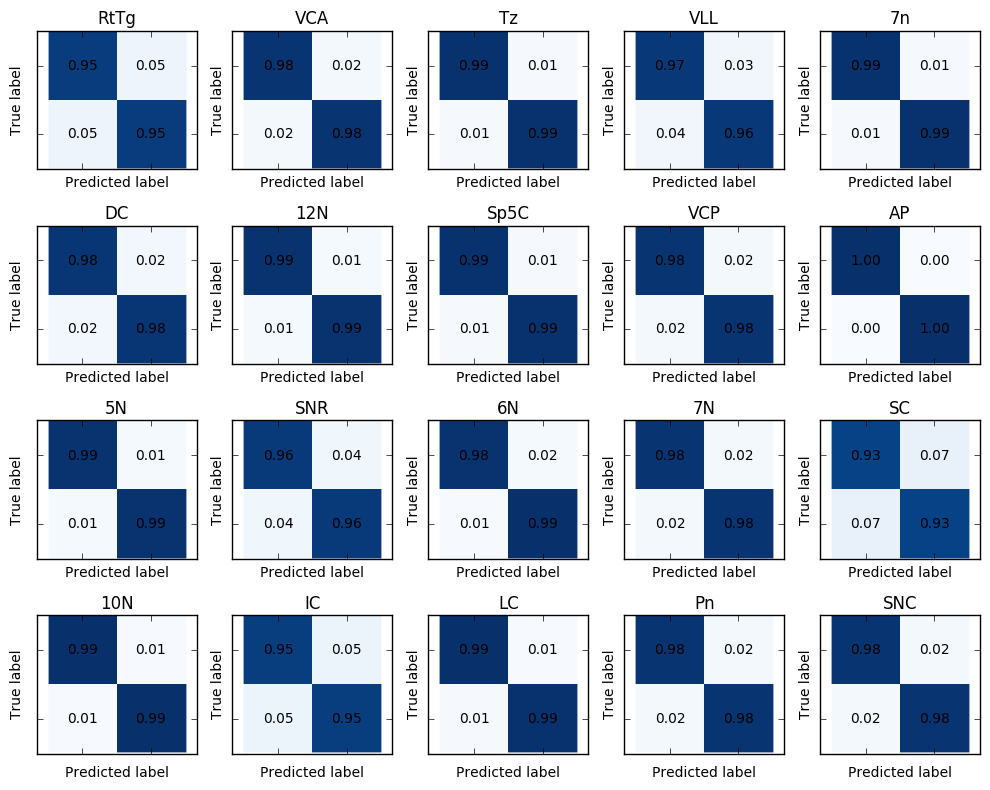

In [69]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    if setting in [1, 3, 4, 5, 6, 7]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
    elif setting in [2, 10]:
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
        for surr_l in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
            if c in labels_found:
                neg_classes.append(c)
    elif setting in [8,9,11]:
        neg_classes = [structure + '_negative']
    else:
        sys.stderr.write('Setting is not recognized.\n')
        raise

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [70]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.978128667503


In [ ]:
# visualize training patches

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP'], 'grid_index')
display_images_in_grids(patches, 5)

patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP_surround'], 'grid_index')
display_images_in_grids(patches, 5, titles=sampled_addresses['AP_surround'])

# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)